# NLP (Natural Language Processing) with Python


### About Dataset: SMSSpamHamCollection
We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The file we are using contains a collection of more than 5 thousand SMS. The first column in given dataset is a *label* saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the *message* itself.


**Objective-**\
Using these labeled *ham* and *spam* examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

#### Importing the Libraries and Dataset:

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
messages = pd.read_csv('SMSSpamHamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Exploratory Data Analysis:

In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [6]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [7]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

#### Data Visualization:

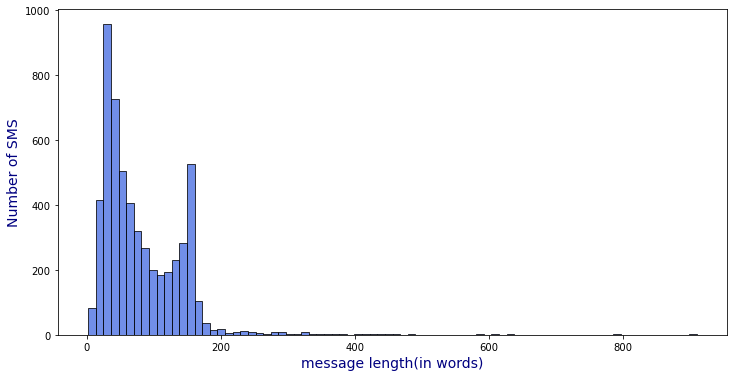

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=messages, x='length', ax=ax,bins=80,color='royalblue')
ax.set_xlabel('message length(in words)', size=14, color='navy')
ax.set_ylabel('Number of SMS', size=14, color='navy')
plt.show()

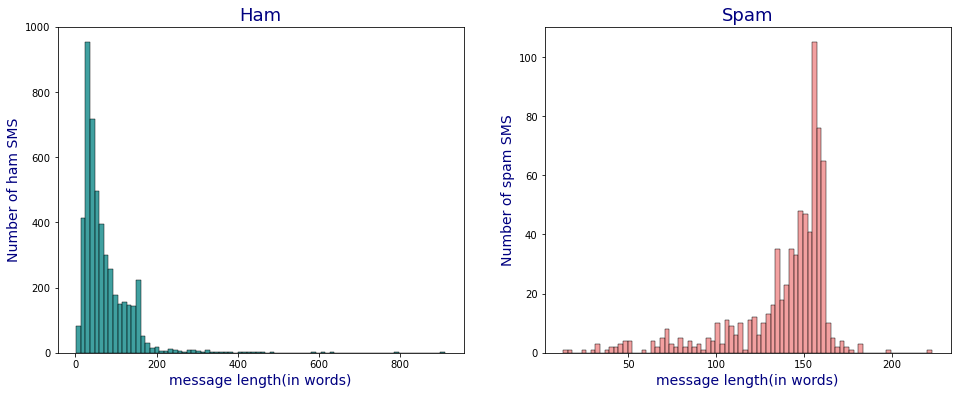

In [9]:
fig,(ax1,ax2)= plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ham=messages[messages['label']=='ham']
sns.histplot(data=ham, x='length', ax=ax1,bins=80,color='teal')
ax1.set_xlabel('message length(in words)', size=14, color='navy')
ax1.set_ylabel('Number of ham SMS', size=14, color='navy')
ax1.set_title('Ham', size=18, color='navy')

spam=messages[messages['label']=='spam']
sns.histplot(data=spam, x='length', ax=ax2,bins=80,color='lightcoral')
ax2.set_xlabel('message length(in words)', size=14, color='navy')
ax2.set_ylabel('Number of spam SMS', size=14, color='navy')
ax2.set_title('Spam', size=18, color='navy')

plt.show()

**Through above Histogram we've been able to discover a trend that spam messages tend to have more characters than ham messages.**

#### Text Pre-processing:
The data is in text format (strings). I'm converting the messages (sequence of characters) into vectors (sequences of numbers) to perform the classification task. This will be done by **bag-of-words** approach, where each unique word in a text will be represented by one number.

In [10]:
import string
from nltk.corpus import stopwords

In [11]:
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation] # Check characters to see if they are in punctuation
    nopunc = ''.join(nopunc) # Join the characters again to form the string.
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')] # to remove any stopwords

In [12]:
messages['message'].head(5).apply(text_process) # Tokenization

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

#### Vectorization
Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message']) # analyzer=previously defined function

print(len(bow_transformer.vocabulary_)) # Print total number of vocab words

11425


Transform the entire DataFrame of *'messages'* by using **.transform** on our Bag-of-Words (bow) transformed object.

In [15]:
messages_bow = bow_transformer.transform(messages['message'])

In [16]:
print('Shape of Sparse Matrix: ', messages_bow.shape)

Shape of Sparse Matrix:  (5572, 11425)


#### TF-IDF(term frequency-inverse document frequency)

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [18]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

#### Training a model
Naive Bayes classifier algorithm

In [19]:
from sklearn.naive_bayes import MultinomialNB

#### Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


#### Creating a Data Pipeline

In [21]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [22]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002484C3A7040>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [23]:
predictions = pipeline.predict(msg_test)

#### Model Evaluation

In [24]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1009
        spam       0.69      1.00      0.82       106

    accuracy                           0.96      1115
   macro avg       0.85      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115

